### Training with augmentation
Code taken from: https://github.com/piergiaj/pytorch-i3d/blob/master/train_i3d.py 

Note: This code was written for PyTorch 0.3. Version 0.4 and newer may cause issues.

Set `augment = True` below for data to be augmented, and `false` otherwise.

In [49]:
is_augment = True

Set `dropout = True` below for dropout to be included, and `false` otherwise.

In [50]:
is_dropout = True

Dropout details:

In [ ]:
dropout_details = "layer1_p0.5"

Set weight decay value, `wd`, below:

In [51]:
wd = 1e-07

Set the number of epochs in training:

In [52]:
num_epochs = 30 

**ALL FILES INCLUDING LOSSES AND THE MODEL WILL BE SAVED WITH THIS NAME:**

In [53]:
# "30epochs_wd_1e-07_dropout__augmented" means the there are 30 training epochs, weight decay is 1e-07, and that there is dropout and augmentation
save_name = f"{num_epochs}epochs_wd_{wd}"
if is_dropout: save_name = save_name + "_dropout_"+dropout_details
if is_augment: save_name = save_name + "_augment"

In [54]:
# check save_name
save_name

'30epochs_wd_1e-07_dropout_augment'

Import packages

In [1]:
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<1024>"
import sys
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import numpy as np
from pytorch_i3d import InceptionI3d
import numpy as np
import glob
import random
from tensorboardX import SummaryWriter
from preprocess import run_preprocessing, get_action, holdout_set
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image, ImageSequence

# video augmentation scripts (c) 2018 okankop
from vidaug import *

Construct a dataset class for training the model:

In [2]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self, paths, v_names, v_labels, num_samples=16, transforms=None): # num_samples cannot be lower than 16
        self.num_samples = num_samples
        self.frames = dict()
        for p in paths:
            self.frames[p] = sorted(glob.glob(p+"/*.jpg"))
        self.data = paths
        self.video_names = v_names
        self.video_labels = v_labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # get original video
        p = self.data[idx]
        
        # sample frames uniformly and create newly sampled video 
        num_frames = len(self.frames[p])-1
        sampled_idx = np.linspace(0, num_frames, self.num_samples) #get num_samples frames from the video
        images = []
        index = np.where(self.video_names == p.split('/')[-1]) #index of p's video name in video_names
        label_video = self.video_labels[index] # the labels for the video
        for i in sampled_idx:
            image = torchvision.io.read_image(self.frames[p][int(i)])
            small_dim = min(image.shape[-2:])
            image = torchvision.transforms.functional.center_crop(image, (small_dim, small_dim))
            image = torchvision.transforms.functional.resize(image, (224, 224), antialias=True)
            images.append(image)
        images = torch.stack(images, axis=1)
        
        # data augmentation 
        if (self.transforms is not None):
            images = np.array(self.transforms(images.numpy()))
            # normalize
            images = (images/255)*2 - 1 # values are between -1 and 1
            return torch.from_numpy(images).type(torch.FloatTensor), label_video 
        
        else: 
            images = (images/255)*2 - 1 #values are between -1 and 1
            return images, label_video 

    def __len__(self):
        return len(self.data)

Extract data and labels

In [3]:
def creating_datasets():
    video_train, video_val, label_train, label_val, unique_labels = holdout_set(0.25) #valid names and videos
    batch_size = 10 # batch size in training
    num_videos_train = len(video_train)
    num_videos_val = len(video_val)
    num_classes = len(set(label_train)) #count unique in labels

    video_frames_path = "/scratch/network/hishimwe/image" 
    # only extract the videos with v_names and v_labels from preprocess.ipynb 
    paths = glob.glob(video_frames_path+"/*")
    random.seed(0)
    random.shuffle(paths)

    good_paths_train = list(filter(lambda c: c.split('/')[-1] in video_train, paths)) #should only get path where good video name; not sure if this filtering will work 
    good_paths_val = list(filter(lambda c: c.split('/')[-1] in video_val, paths)) # validation video paths 

    d_train = dataset(paths=good_paths_train, v_names=video_train, v_labels= label_train)
    d_val = dataset(paths=good_paths_val, v_names=video_val, v_labels= label_val)

    loader_train = torch.utils.data.DataLoader(d_train, shuffle=True, batch_size=batch_size, drop_last=False, num_workers=4)
    loader_val = torch.utils.data.DataLoader(d_val, shuffle=True, batch_size=batch_size, drop_last=False, num_workers=4)
    
    return loader_train, loader_val, unique_labels, num_classes

Build transformations for data augmentation

In [4]:
sometimes = lambda aug: Sometimes(0.3, aug) # Used to apply augmentor with 30% probability
rand_aug = SomeOf([ # randomly chooses two of the following augmentation methods 
    RandomRotate(degrees=10), # randomly rotates the video with a degree randomly choosen from [-10, 10] 
    RandomTranslate(x=40,y=20), # randomly shifting video in [-x, +x] and [-y, +y] coordinate
    RandomShear(x=0.2,y=0.1), # randomly shearing video in [-x, +x] and [-y, +y] directions.
    sometimes(HorizontalFlip()), # horizontally flip the video with 50% probability
    sometimes(GaussianBlur(sigma=random.uniform(0.5,4))), # blur images using gaussian kernels with std. dev. = sigma
    sometimes(ElasticTransformation(alpha=random.uniform(0,5), cval=int(random.uniform(0,255)), mode="nearest")), # moving pixels locally around using displacement fields
    sometimes(PiecewiseAffineTransform(displacement=15, displacement_kernel=1, displacement_magnification=1)), # places a regular grid of points on an image and randomly moves the neighbourhood of these point around via affine transformations
    sometimes(InvertColor()), # inverts the color of the video
    sometimes(Add(value=int(random.uniform(-100,100)))), # add a value to all pixel intesities in an video
    sometimes(Multiply(value=2)), # multiply all pixel intensities with given value
    sometimes(Multiply(value=0.5)), # multiply all pixel intensities with given value
    sometimes(Pepper(ratio=25)), # sets a certain fraction of pixel intensities to 0
    sometimes(Salt(ratio=25)), # sets a certain fraction of pixel intensities to 255
], 2)

Build and load data

In [6]:
%time loader_train, loader_val, unique_labels, num_classes = creating_datasets() 

CPU times: user 8.74 s, sys: 644 ms, total: 9.39 s
Wall time: 37.8 s


Check what the data looks like by looking at the first frame of the first video (might be augmented):

In [14]:
data = []
labels = []
i=0
for d, l in loader_train:
    data.append(d)
    labels.append(l)
    i+=1
    if i != 0: break

In [23]:
first_video, first_label = data[0][0], l[0]

In [24]:
first_frame = first_video[:,0,:,:]
first_frame = (first_frame+1)/2

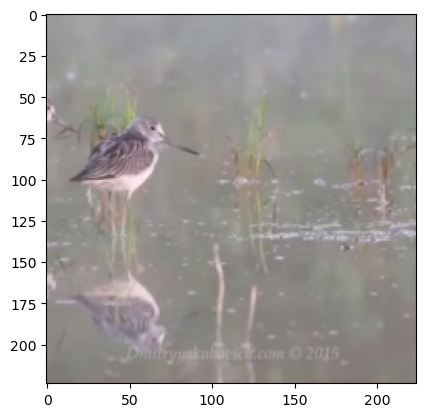

In [25]:
plt.imshow(first_frame.numpy().transpose(1,2,0))

The video above corresponds to the following action:

In [27]:
get_action(first_label, unique_labels)

array(['Attending'], dtype=object)

Construct the model:

In [28]:
start_time = time.time() 
i3d = InceptionI3d(400, in_channels=3) # first input is num_classes in kinetics, this is replaced with replace_logits

if dropout: i3d.load_state_dict(torch.load('rgb_imagenet.pt'), strict=False) #added strict = false; theoretically this lets us add layers
else: i3d.load_state_dict(torch.load('rgb_imagenet.pt')) 

i3d.replace_logits(num_classes)
i3d.cuda()

print(f"time taken: {time.time()-start_time} seconds")

time taken: 0.976132869720459 seconds


Function to evaluate model performance:

In [30]:
#returns accuracy, f1 score, average f1, and confusion matrix for the data
def eval_metrics(ground_truth, predictions, num_classes):

    #dictionary containing the accuracy, precision, f1, avg f1, and confusion matrix for the data
    f1 = f1_score(y_true=ground_truth, y_pred=predictions, labels=np.arange(num_classes), average=None)
    metrics = {
        "accuracy": accuracy_score(y_true=ground_truth, y_pred=predictions),
        "f1": f1,
        "average f1": np.mean(f1),
        "confusion matrix": confusion_matrix(y_true=ground_truth, y_pred=predictions, labels=np.arange(num_classes)),
        "precision": precision_score(y_true=ground_truth, y_pred=predictions, labels=np.arange(num_classes), average=None)
        }
    
    return metrics

Function to train and validate:

In [6]:
def training(model, optimizer, loader, num_classes):
    losses = []
    ground_truth = []
    predictions = []
    for data, label in loader:
        data = data.cuda()
        label = label.squeeze().type(torch.LongTensor).cuda()
        num_frames = data.size(2)
        per_frame_logits = i3d(data).mean(2)
        preds = per_frame_logits.cpu().detach().numpy().argmax(axis=1) # convert logits into predictions for evaluating accuracy
        
        # calculate and save loss
        loss = F.cross_entropy(per_frame_logits, label)
        losses.append(loss.item()) # append to losses
        ground_truth.extend(list(label.cpu().detach().numpy()))
        predictions.extend(preds.tolist())
        
        # perform gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    metrics = eval_metrics(ground_truth, predictions, num_classes)   
    return np.mean(losses), metrics # one loss per epoch and the corresponding metrics        


In [ ]:
def evaluate(model, loader, num_classes):
    losses = []
    ground_truth = []
    predictions = []
    for data, label in loader:
        data = data.cuda()
        label = label.squeeze().type(torch.LongTensor).cuda()
        num_frames = data.size(2)
        per_frame_logits = i3d(data).mean(2)
        preds = per_frame_logits.cpu().detach().numpy().argmax(axis=1) # convert logits into predictions for evaluating accuracy
        
        # calculate and save loss
        loss = F.cross_entropy(per_frame_logits, label)
        losses.append(loss.item()) # append to losses
        ground_truth.extend(list(label.cpu().detach().numpy()))
        predictions.extend(preds.tolist())
        
    metrics = eval_metrics(ground_truth, predictions, num_classes)
    return np.mean(losses), metrics # one loss per epoch and the corresponding metrics
    

Train

In [12]:
# set up gradient descent params
optimizer = optim.SGD(i3d.parameters(), lr=0.1, momentum=0.9, weight_decay=wd) # weight_decay = l2 regularization
lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])

# save performance
train_losses = []
train_accuracies = []
train_precisions = []
val_losses = []
val_accuracies = []
val_precisions = []

# train
for e in range(num_epochs):
    start_time = time.time()
    
    print("EPOCH", e)
    
    # training
    loss_train, metrics_train = training(model=i3d, optimizer=optimizer, loader=loader_train, num_classes=num_classes)
    train_losses.append(loss_train)
    train_accuracies.append(metrics_train["accuracy"])
    train_precisions.append(metrics_train["precision"])
    
    print("TRAINING")
    print("Loss", loss_train)
    print("Accuracy", metrics_train["accuracy"])
    print("Precision", metrics_train["precision"])
    
    # validation 
    loss_val, metrics_val = evaluate(model=i3d, loader=loader_val, num_classes=num_classes)
    val_losses.append(loss_val)
    val_accuracies.append(metrics_val["accuracy"])
    val_precisions.append(metrics_val["precision"])
    
    print("VALIDATION")
    print("Loss", loss_val)
    print("Accuracy", metrics_val["accuracy"])
    print("Precision", metrics_val["precision"])
        
    print(f"Time taken for epoch {e}: {(time.time()-start_time)/60} mins")
    print("-----------------------------------------------------------------------")

np.savetxt('losses/train/train_'+ save_name, np.array(train_losses), delimiter=",")
np.savetxt('losses/val/val_' + save_name, np.array(val_losses), delimiter=",")

np.savetxt('accuracies/train/train_'+save_name, np.array(train_accuracies), delimiter=",")
np.savetxt('accuracies/val/val_'+save_name, np.array(val_accuracies), delimiter=",")

np.savetxt('precisions/train/train_'+save_name, np.array(train_precisions), delimiter=",")
np.savetxt('precisions/val/val_',+save_name np.array(val_precisions), delimiter=",")


OutOfMemoryError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 15.89 GiB total capacity; 573.07 MiB already allocated; 197.12 MiB free; 580.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(train_losses)
print(val_losses)
print(train_accuracies)
print(val_accuracies)

Save model

In [ ]:
model_path = "models/" + save_name 
torch.save(i3d, model_path)

Check saved output

In [ ]:
torch.load(model_name)